# Notebook to train a ML model to learn barriers

## Initial setup: Generation of amorphous 2D lattice and strucuture optimizations to compute grafting barriers

In [ ]:
pip install metric_learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Standard libraries
import json
import matplotlib
# pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.integrate as integrate
import seaborn as sns
from matplotlib import animation
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from matplotlib.offsetbox import AnchoredText
from matplotlib import cm
import matplotlib.ticker as ticker

# non-pip
from potentials import *
from visualization import *
from lattice import *
from il import *
from il_pedagogical import *




# set lattice size (the lattice size will be lattice_size*lattice_size). To get ~ 20000 sites choose lattice_size=1500
lattice_size = 1500
# temperature
T = 298.15
# covariance of random perturbations to lattice to generate disorder
cov = 0.00022
displacement_type = 'normal'
disp_kwargs = {'covariance' : [[cov, 0], [0, cov]]}


# fraction of empty, OH, and siloxane sites
empty_fraction = 0.3
OH_fraction = 0.3
siloxane_fraction = 0.4



# Morse potential constants for reaction (see "Grafting metal complexes onto amorphous supports: from elementary steps to catalyst site populations via kernel regression" for details)
D_MO = 524.4
r_eq_MO = 1.
a_MO = 1.9

D_M_O = 120.
r_eq_M_O = 1.16
a_M_O = 2.3

E_MA = 160.

MO_Morse = {'D' : D_MO, 'a' : a_MO, 'r_eq' : r_eq_MO}
siloxane_Morse = {'D' : D_M_O, 'a' : a_M_O, 'r_eq' : r_eq_M_O}
lattice_fractions = {'empty' : empty_fraction, 'OH' : OH_fraction, 'Siloxane' : siloxane_fraction}


# generate lattice
lattice = make_quenched_disorder_lattice(lattice_size, cov, True, False)
decorated_lattice = decorate_lattice(lattice, empty_fraction, OH_fraction, siloxane_fraction)

# find sites that can graft
graftable_sites, competing_sites = locate_grafting_sites(decorated_lattice)

# local coordinates to define local site environment
local_coordinates = compute_local_coordinates(decorated_lattice, graftable_sites)
local_coordinates = local_coordinates[:,0:3]
local_coordinates_dict = {'OH-OH-distance' : local_coordinates[:, 0],
                            'siloxane-distances' : local_coordinates[:, 1],
                            'OH-siloxane-angle' : local_coordinates[:, 2]}



# calculate grafting free energy barriers
graft_E, ads_E = grafting_energies(MO_Morse, siloxane_Morse, E_MA, T, graftable_sites, decorated_lattice)
graft_E_non_d = 0.5*graft_E
#offset by 131.3 just for plotting purposes
graft_E = 131.3+0.5*graft_E




/content/il_pedagogical.py:160: SyntaxWarning: invalid escape sequence '\i'
  output = 'C:\\Users\\Craig\\Desktop\\repos\il-pedagogical\\logs\\morse_potential_{}.json'.format(initial_pool_size)


## Calculate evolving population of sites and evolving total surface sites

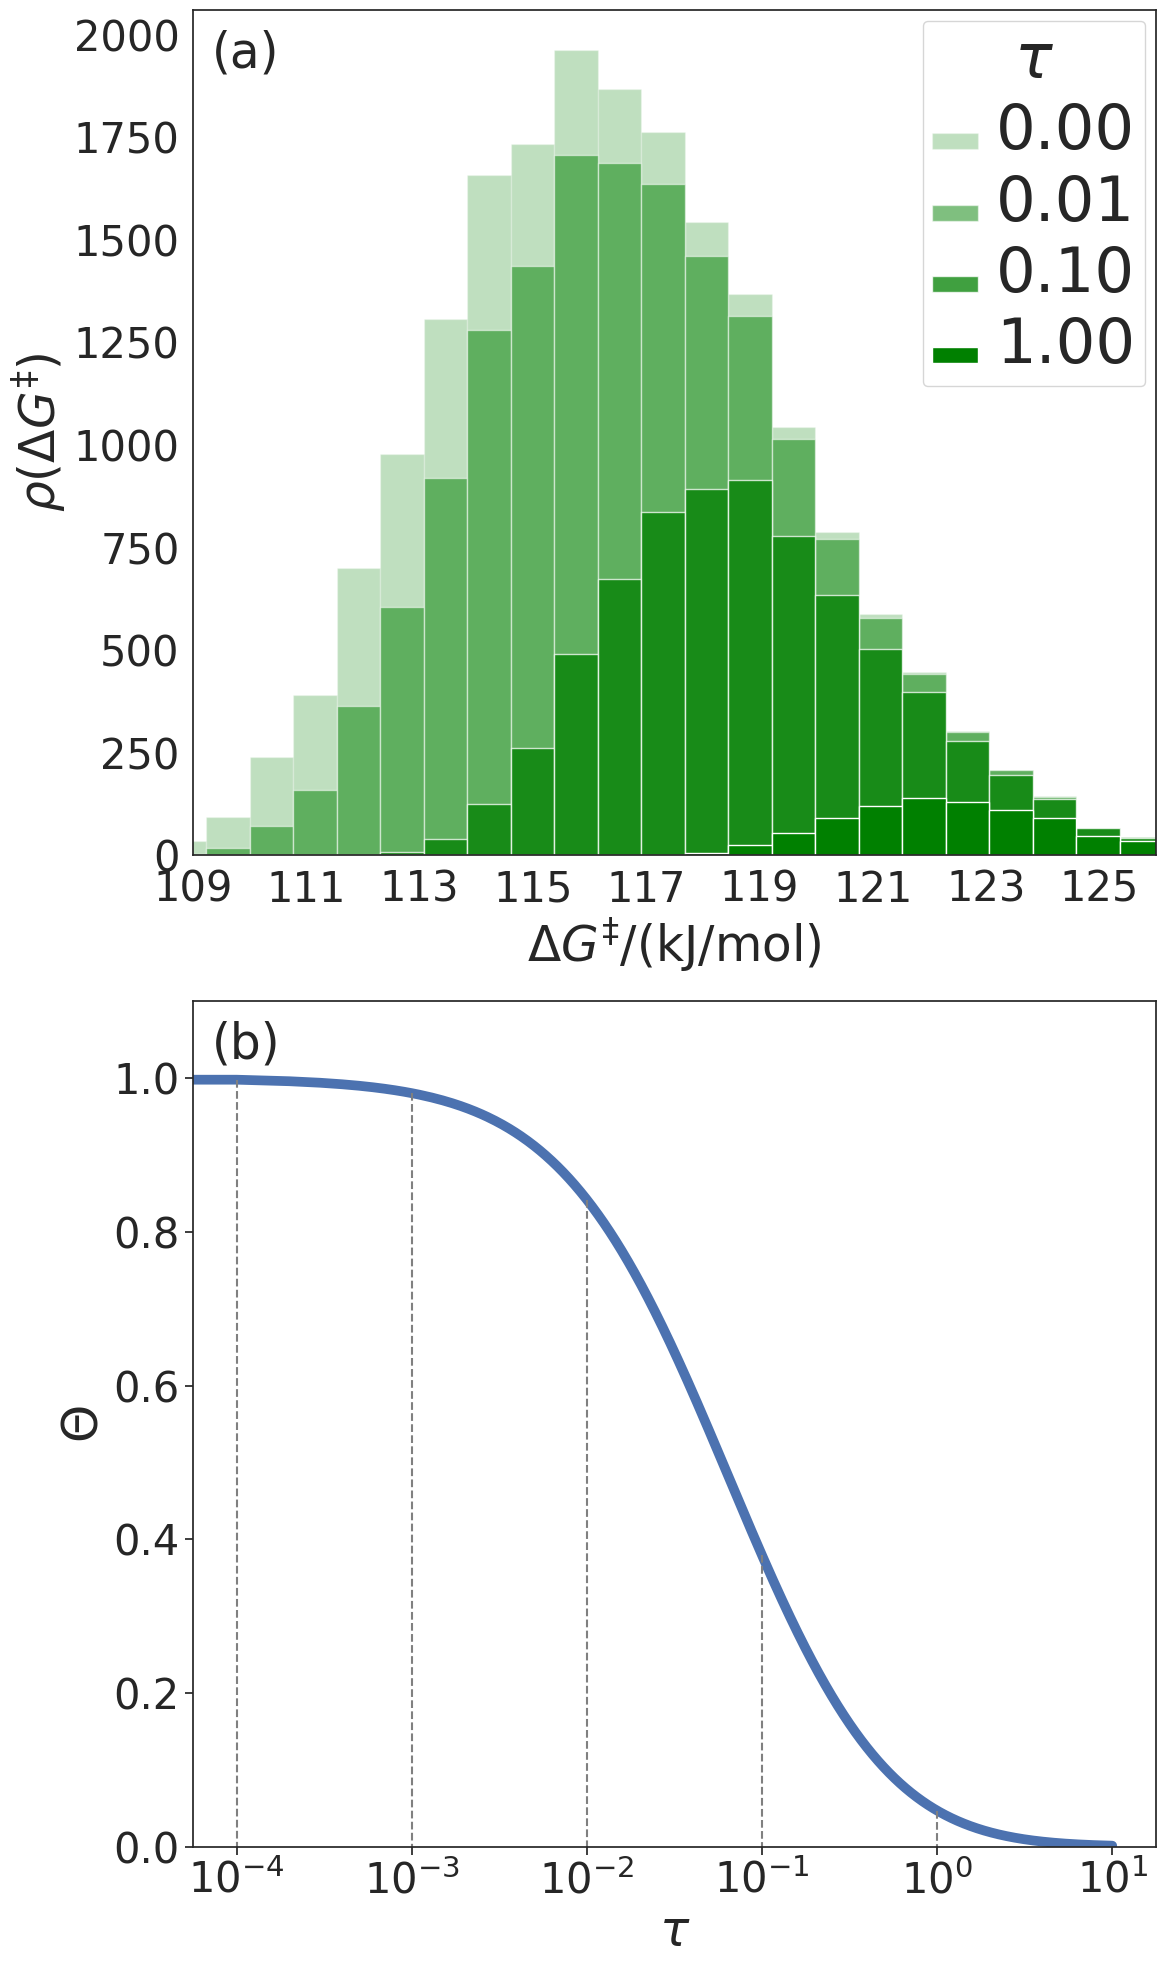

In [ ]:
# calculate the time evolution of the reaction of sites and plot
fig, axes = plt.subplots(2, 1, figsize=(12, 20))

# choose number of bins to plot grafting barrier distribution
n_bins = 30
hist_data, bin_edges = np.histogram(graft_E, bins = n_bins)

# times at which evolving population should be plot
time = [0, 0.01, 0.1, 1]
hist_data_final = hist_data
bin_edges_final = bin_edges
mid_hist = np.asarray([(bin_edges[i]+bin_edges[i+1])/2 for i in range(np.shape(bin_edges)[0]-1)])
lattice_len = int(np.sqrt(len(graft_E)) + 2)
n_sites = np.shape(graft_E)[0]
wid = mid_hist[2] - mid_hist[1]

axes[0].set_xlim((109, 126))

# plot evolving population
for counter, i in enumerate(time):
    h_mod = histogram_graft_mod_non_dim(hist_data, bin_edges, i, T)

    if counter == 0:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.00", color = 'green')
    elif counter == 1:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.01", color = 'green')
    elif counter == 2:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.10", color = 'green')
    elif counter == 3:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "1.00", color = 'green')



props = dict(boxstyle='round', facecolor='white', alpha=0.0)

# axes properties
axes[0].set_xlabel(r'$\Delta G^{\ddag}$/(kJ/mol)',fontsize = 35)
axes[0].set_ylabel(r'$\rho(\Delta G^{\ddag})$',fontsize = 35)
axes[0].set_xlim(109, 126)
axes[0].xaxis.set_ticks(np.arange(109, 126, 2))
axes[0].tick_params(axis = "x", labelsize = 30)
axes[0].tick_params(axis = "y", labelsize = 30)



# set legend
leg1 = axes[0].legend(title=r'$\tau$')
plt.setp(leg1.get_title(), fontsize = 45)
plt.setp(leg1.get_texts(), fontsize = 45)


# make second plot with evolcing total vicinal site population
time = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
time = np.linspace(0,10,100000)
left_silanols = np.zeros(np.shape(time)[0])


# plot
for counter, i in enumerate(time):
    left_silanols[counter]= np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, i, T))/(np.shape(graft_E)[0])

# label axes
axes[1].set_xlabel(r'$\tau$',fontsize = 35)
axes[1].set_ylabel(r"$\Theta$",fontsize = 35)
axes[1].plot(time, left_silanols, linewidth = 7.0)



# add grid lines
axes[1].plot([0.0001, 0.0001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.0001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.001, 0.001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.01, 0.01],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.01, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.1, 0.1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([1, 1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([10.0, 10.0],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 10.0, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')

axes[1].tick_params(left='true', bottom='true')


# add a and b labels to image
anchored_text1 = AnchoredText("(a)", borderpad=0., loc=2,frameon=False,prop=dict(fontsize=35))
anchored_text2 = AnchoredText("(b)", borderpad=0., loc=2,frameon=False,prop=dict(fontsize=35))
axes[0].add_artist(anchored_text1)
axes[1].add_artist(anchored_text2)


#set axes limits
axes[1].set_ylim([0, 1.1])
#set log scale
axes[1].set_xscale('log')
# label size
axes[1].tick_params(axis = "x", labelsize = 30)
axes[1].tick_params(axis = "y", labelsize = 30)



plt.tight_layout()
plt.show()




## Train a metric learning model to predict grafting barriers using a small training set

In [ ]:
!pip install --upgrade metric-learn

In [ ]:
# randomly sample some sites from the total and learn their grafting barriers as a function of the local environment

# number of samples
n_samples=100
sampled_sites, rand_state=sample_sites(graft_E, n_samples, 484, False)
sampled_heights=graft_E[sampled_sites]
sampled_coordinates=local_coordinates[sampled_sites]
sampled_barrier_heights=sampled_heights[0:100]
sampled_local_coordinates=sampled_coordinates[0:100]
X_train=sampled_local_coordinates
Y_train=sampled_barrier_heights


# train and return the Mahalanobis matrix and model predicted barriers

print(np.size(X_train),np.size(Y_train))
M, model_barriers_LOO, residuals = train(X_train, Y_train)

# plot traning
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

print("delta shape:", delta.shape)
print("M shape:", M.shape)
print("Transpose delta shape:", np.transpose(delta).shape)

plot_trained(ax, 10, model_barriers_LOO, sampled_barrier_heights, 2.5, 100)
ax.set_xlabel(r'True $\Delta G^{\ddag}$/(kJ/mol)', fontsize = 40)
ax.set_ylabel(r'Model $\Delta \^G^{\ddag}$/(kJ/mol)', fontsize = 40)
ax.tick_params(axis = "x", labelsize = 30)
ax.tick_params(axis = "y", labelsize = 30)

ax.set_xlim([112,124])
ax.set_ylim([112,124])
plt.show()


300 100


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

## Performance of ML model on the test set (all sites)

In [ ]:
# predict grafting barriers fo all sites using ML model trained on a small set of sites



# predict barriers
model_barrier_heights = predicted_adsorption_energies(sampled_local_coordinates, sampled_barrier_heights, M, local_coordinates,np.shape(graft_E)[0])


# errors made by machine learning model
residuals = graft_E - model_barrier_heights


# plot the residuals
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
sns.distplot(residuals, bins=50, color="grey")
ax.set_xlabel(r'(True ${\Delta}G^{\ddag}$ - Model ${\Delta}\^G^{\ddag}$)/(kJ/mol)', fontsize = 40)
ax.set_ylabel('Frequency of Residuals', fontsize = 40)
ax.tick_params(axis = "x", labelsize = 40)
ax.tick_params(axis = "y", labelsize = 40)
ax.set_xlim([-2,2])
textstr = '$\sigma$='+str(round(np.sqrt(np.var(graft_E-model_barrier_heights)),2))
props = dict(boxstyle='round', facecolor='white', alpha=0.0)

ax.text(0.4, 0.2, textstr, transform=ax.transAxes, fontsize=40,
        verticalalignment='top', bbox=props)

ax.tick_params(left='true', bottom='true')
plt.tight_layout()
plt.show()

## Errors on the test set as a function of training set size

In [ ]:
# residulas as a function of training set size

# array containing number of samples
n_samples=[25, 100, 200, 400]




plt.rcParams['figure.figsize'] = 11, 11
fig = plt.figure()


for i, l in enumerate(n_samples):
    # train model with different sample size
    sampled_barrier_heights = sampled_heights[0:l]
    sampled_local_coordinates = sampled_coordinates[0:l]
    ax = fig.add_subplot(2, 2, i+1)
    M, model_barriers_LOO, residuals = train(sampled_local_coordinates, sampled_barrier_heights)
    model_barrier_heights = predicted_adsorption_energies(sampled_local_coordinates, sampled_barrier_heights, M, local_coordinates,np.shape(graft_E)[0])


    # calculate residuals
    residuals = graft_E - model_barrier_heights

    # plot residuals
    sns.distplot(residuals, bins=50, color="grey")

    if i == 0 or i == 2:
        ax.set_ylabel('Frequency of Residuals')
    if i == 2 or i == 3:
        ax.set_xlabel(r'(True ${\Delta}G^{\ddag}$ - Model ${\Delta}\^G^{\ddag}$)/(kJ/mol)')

    ax.set_xlim([-2,2])
    ax.set_ylim([0,1.4])
    ax.set_title('Training set size ='+str(l))
    if i == 0 or i == 1:
        ax.set_xticklabels([])
    if i == 1 or i == 3:
        ax.set_yticklabels([])

    if i == 1:
        textstr = '$\sigma$=0.48'
    else:
        textstr = '$\sigma$='+str(round(np.sqrt(np.var(graft_E-model_barrier_heights)),2))

    props = dict(boxstyle='round', facecolor='white', alpha=0.0)

    ax.text(0.4, 0.2, textstr, transform=ax.transAxes, fontsize=25,
            verticalalignment='top', bbox=props)


plt.tight_layout()
plt.show()

## Evolving population of sites and evolving total surface sites as predicted by the ML model

In [ ]:
# predicting the evolving population using the ML model


# times at which population should be plotted
time = [0, 0.01, 0.1, 1]

# number of bins to plot population plots
n_bins = 30

# number of samples
n_samples = 100


# trained model
M, model_barriers_LOO, residuals = train(sampled_coordinates[0:n_samples,0:2], sampled_heights[0:n_samples])
model_heights = predicted_adsorption_energies(sampled_coordinates[0:n_samples,0:2], sampled_heights[0:n_samples], M, local_coordinates[:,0:2],np.shape(graft_E)[0])

# predicted histogram
hist_data_predicted, bin_edges_predicted = np.histogram(model_heights, bins = bin_edges_final)
mid_hist_predicted = np.asarray([(bin_edges_predicted[i]+bin_edges_predicted[i+1])/2 for i in range(np.shape(bin_edges)[0]-1)])
wid = mid_hist_predicted[2]-mid_hist_predicted[1]
mid_hist_final = np.asarray([(bin_edges_final[i]+bin_edges_final[i+1])/2 for i in range(np.shape(bin_edges_final)[0]-1)])
wid_final = mid_hist_final[2]-mid_hist_final[1]


# plot evolving population
fig, axes = plt.subplots(2, 1, figsize=(12, 20))
for counter, i in enumerate(time):
    h_mod = histogram_graft_mod_non_dim(hist_data_predicted, bin_edges_final, i, T)
    if counter == 0:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.00", color = 'green')
    elif counter == 1:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.01", color = 'green')
    elif counter == 2:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "0.10", color = 'green')
    elif counter == 3:
        axes[0].bar(mid_hist, height = h_mod, width = wid, alpha = 1.0*(counter+1)/len(time), label =  "1.00", color = 'green')


# axes properties
axes[0].set_xlim((109, 126))
axes[0].set_ylabel(r'$\rho(\Delta G^{\ddag})$', fontsize = 40)
axes[0].set_xlabel(r'$\Delta G^{\ddag}/(kJ/mol)$', fontsize = 40)
axes[0].xaxis.set_ticks(np.arange(109, 126, 2))
axes[0].tick_params(left='true', bottom='true')

axes[0].tick_params(axis = "x", labelsize = 40)
axes[0].tick_params(axis = "y", labelsize = 40)

leg1 = axes[0].legend(title=r'$\tau$')

plt.setp(leg1.get_title(), fontsize = 45)
plt.setp(leg1.get_texts(), fontsize = 45)



# make second plot with evolcing total vicinal site population

time = np.linspace(0,10,100000)
time_pred = [0.0001, 0.0003333, 0.001, 0.003333, 0.01, 0.03333, 0.1, 0.3333, 1.0, 3.333, 10.0]
left_silanols_predicted = np.zeros(np.shape(time_pred)[0])


for counter, i in enumerate(time_pred):
    left_silanols_predicted[counter]= np.sum(histogram_graft_mod_non_dim(hist_data_predicted, bin_edges, i, T))/(np.shape(graft_E)[0])




# adding grid lines
axes[1].plot([0.0001, 0.0001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.0001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.001, 0.001],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.001, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.01, 0.01],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.01, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([0.1, 0.1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 0.1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([1, 1],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 1, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')
axes[1].plot([10.0, 10.0],[np.sum(histogram_graft_mod_non_dim(hist_data, bin_edges, 10.0, T))/(np.shape(graft_E)[0]), 0.0], color='grey', linestyle = 'dashed')

# axes properties
axes[1].tick_params(left='true', bottom='true')
axes[1].legend( prop={'size':  25})
axes[1].tick_params(left='true')
axes[1].set_ylim([0, 1.1])
axes[1].set_xscale('log')
axes[1].tick_params(axis = "x", labelsize = 30)
axes[1].tick_params(axis = "y", labelsize = 30)
axes[1].set_xlabel(r'$\tau$',fontsize = 45)
axes[1].set_ylabel(r"$\Theta$",fontsize = 45)
axes[1].plot(time, left_silanols, label = 'Using 19358 barriers', linewidth = 7.0)
axes[1].plot(time_pred, left_silanols_predicted, 'x', label = 'Using kernel regression', markersize=20, markeredgewidth=5)
leg = plt.legend()



plt.tight_layout()

plt.show()


## Plot predicted grafting barriers as a function of important local coordinates

NameError: name 'sampled_coordinates' is not defined

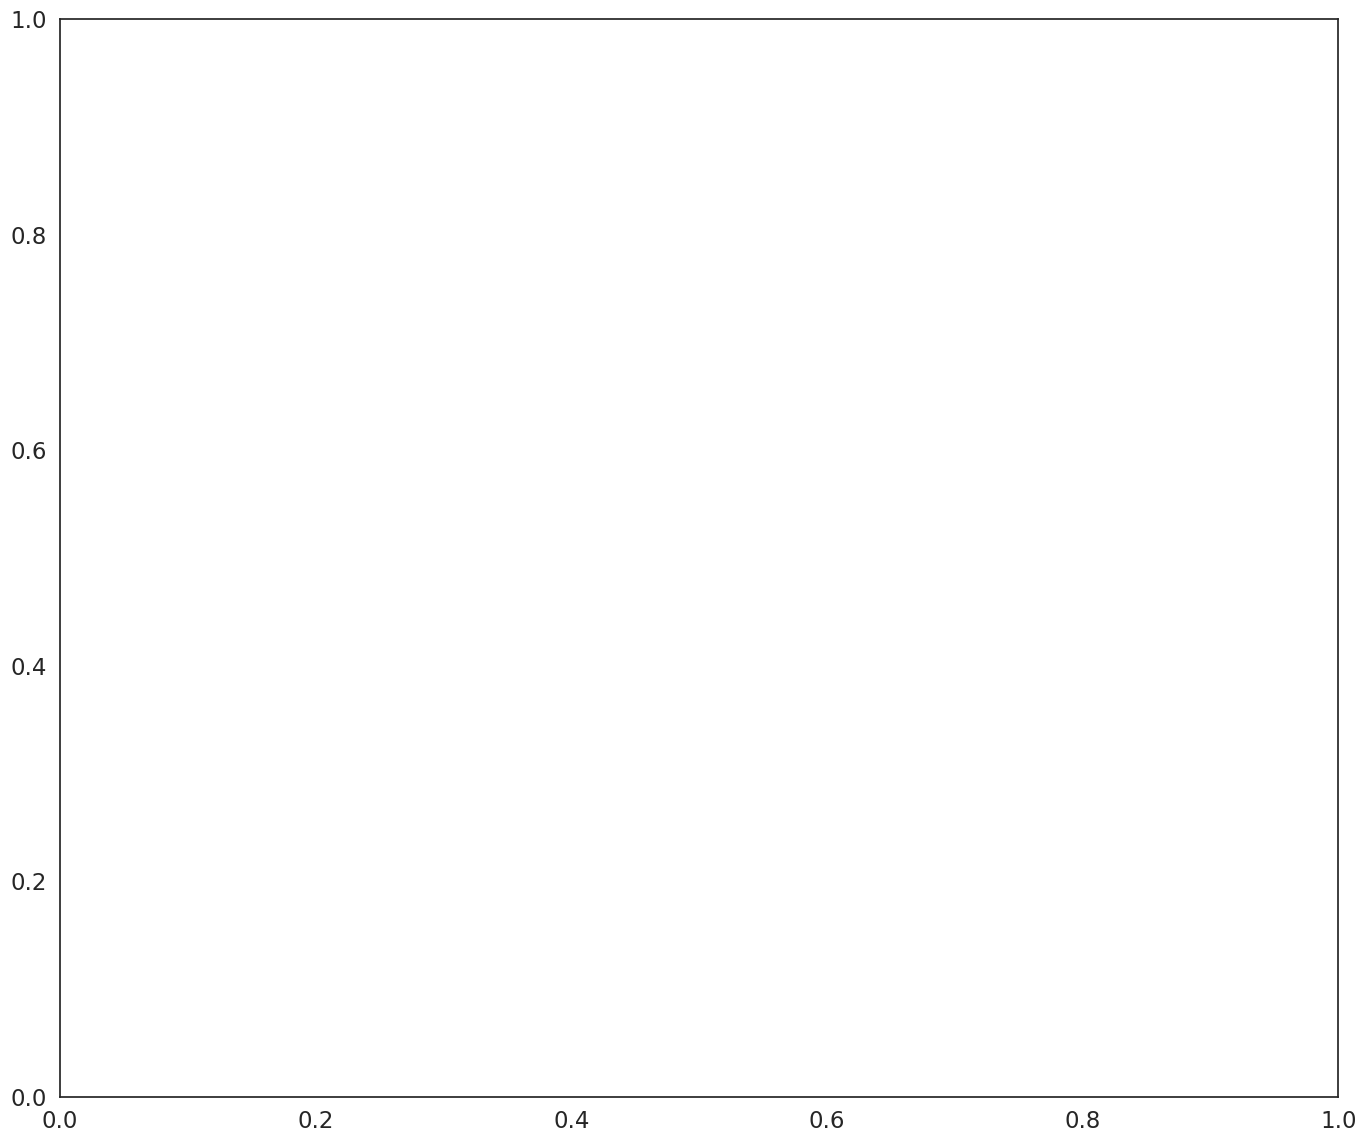

In [ ]:
# plot predicted grafting barriers as a function of important coordinates

fig, axs = plt.subplots(1, 1, figsize=(16.5, 14), sharey=True)


# plot model predicted barriers vs d1 and d2
v = np.linspace(min(graft_E), max(graft_E), 20, endpoint=True)
sampled_local_coordinates = sampled_coordinates
tri2 = axs.tricontourf(local_coordinates[:,0], local_coordinates[:, 1], model_heights,v, cmap=cm.Greens)
axs.scatter(sampled_local_coordinates[0:n_samples,0], sampled_local_coordinates[0:n_samples,1], s=150, c='blue', edgecolors='black', label='Initial Pool')


# axes properties
axs.set_xlabel(r'$d_1$',fontsize='40')
axs.set_ylabel(r'$d_2$',fontsize='40')
axs.tick_params(labelsize='40')
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cb2 = fig.colorbar(tri2, ax=axs, format=ticker.EngFormatter(places=0))
cb2.ax.tick_params(labelsize=40)
tick_positions_x = [1.90, 1.95, 2.00, 2.05, 2.10]
axs.set_xticks(tick_positions_x)
axs.set_xticklabels([i for i in tick_positions_x])
tick_positions_y = [1.95, 2.00, 2.05, 2.10]
axs.set_yticks(tick_positions_y)
axs.set_yticklabels([i for i in tick_positions_y])
axs.tick_params(left='true', bottom='true')
axs.tick_params(axis = "x", labelsize=40)
axs.tick_params(axis = "y", labelsize=40)
axs.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs.set_xlim([1.91, 2.09])
axs.set_ylim([1.91, 2.09])

plt.tight_layout()
plt.show()


In [ ]:
# MO_Morse = {'D' : D_MO, 'a' : a_MO, 'r_eq' : r_eq_MO}
# siloxane_Morse = {'D' : D_M_O, 'a' : a_M_O, 'r_eq' : r_eq_M_O}
# lattice_fractions = {'empty' : empty_fraction, 'OH' : OH_fraction, 'Siloxane' : siloxane_fraction}


# # generate lattice
# lattice = make_quenched_disorder_lattice(lattice_size, cov, True, False)
# decorated_lattice = decorate_lattice(lattice, empty_fraction, OH_fraction, siloxane_fraction)

# # find sites that can graft
# graftable_sites, competing_sites = locate_grafting_sites(decorated_lattice)

# # local coordinates to define local site environment
# local_coordinates = compute_local_coordinates(decorated_lattice, graftable_sites)
# local_coordinates = local_coordinates[:,0:3]
# local_coordinates_dict = {'OH-OH-distance' : local_coordinates[:, 0],
#                             'siloxane-distances' : local_coordinates[:, 1],
#                             'OH-siloxane-angle' : local_coordinates[:, 2]}



# # calculate grafting free energy barriers
# graft_E, ads_E = grafting_energies(MO_Morse, siloxane_Morse, E_MA, T, graftable_sites, decorated_lattice)
# graft_E_non_d = 0.5*graft_E
# #offset by 131.3 just for plotting purposes
# graft_E = 131.3+0.5*graft_E
import numpy as np

np.size(local_coordinates)
print(np.size(graft_E))
print(local_coordinates)
print(np.size(local_coordinates,0))

19368
[[ 2.00744203  2.00740186 89.81181751]
 [ 2.03289767  2.00767519 89.05306543]
 [ 1.98712037  2.02549439 90.27880117]
 ...
 [ 1.96501321  2.0191877  89.11009642]
 [ 2.00285851  2.02585665 90.16379463]
 [ 2.00233479  1.98960641 90.07816349]]
19368


In [ ]:
19368*3
print(graft_E)
#58104

[115.01486776 112.71628101 115.44325585 ... 118.55235429 113.37293987
 116.9704931 ]


In [ ]:
n = 19368
import random
from metric_learn import MLKR

In [ ]:
random_indices = random.sample(range(n), 100)

In [ ]:
X_sample = local_coordinates[random_indices]
Y_sample = graft_E[random_indices]

In [ ]:
mlkr = MLKR()
X_transformed = mlkr.fit_transform(X_sample, Y_sample)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_transformed, Y_sample)

KNeighborsRegressor()

In [ ]:
y_pred = knn.predict(X_transformed)

In [ ]:
error = np.abs(y_pred - Y_sample)

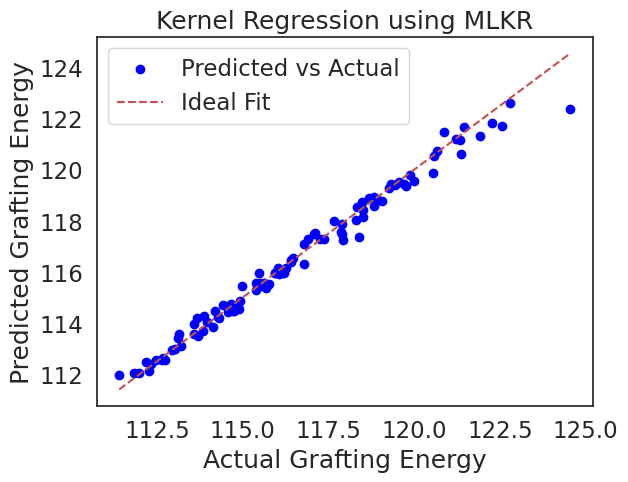

In [ ]:
plt.scatter(Y_sample, y_pred, c='blue', label='Predicted vs Actual')
plt.plot([min(Y_sample), max(Y_sample)], [min(Y_sample), max(Y_sample)], 'r--', label='Ideal Fit')
plt.xlabel('Actual Grafting Energy')
plt.ylabel('Predicted Grafting Energy')
plt.legend()
plt.title('Kernel Regression using MLKR')
plt.show()

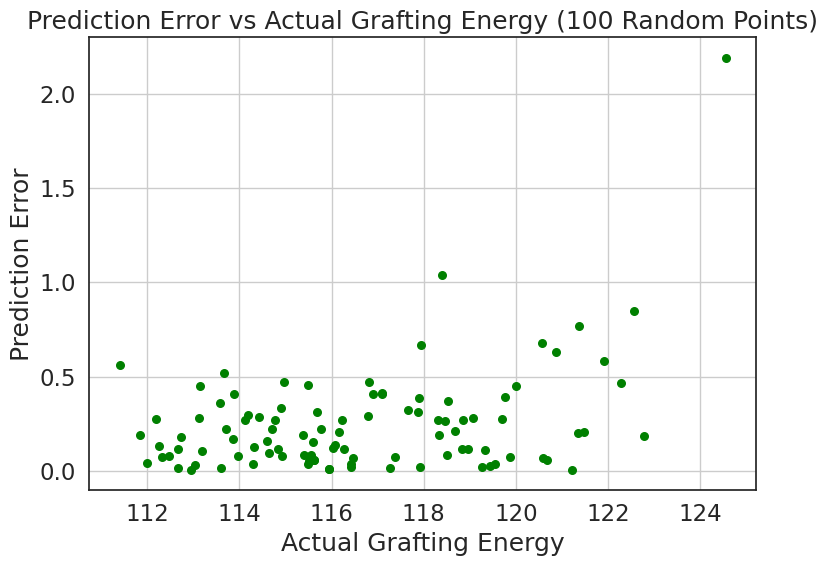

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_sample, error, c='green', s=30)
plt.xlabel('Actual Grafting Energy')
plt.ylabel('Prediction Error')
plt.title('Prediction Error vs Actual Grafting Energy (100 Random Points)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# error vs actual energy
#histogram(2 plots for actual grafting energy and predicted energy)

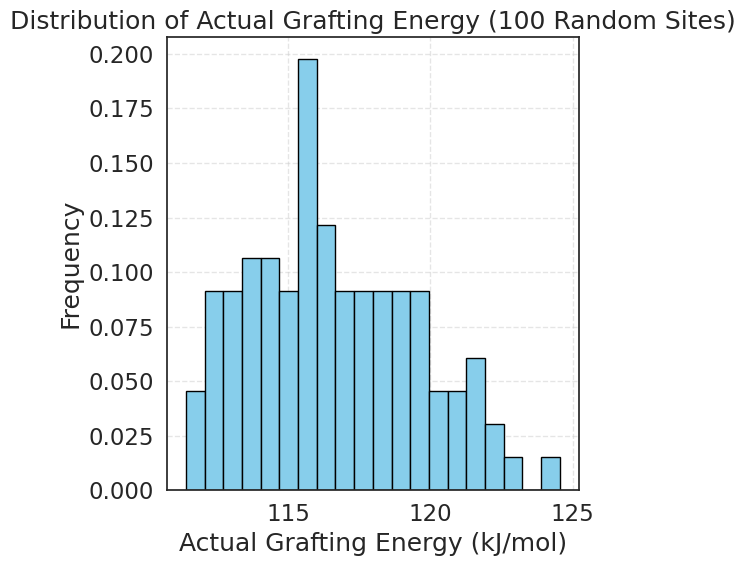

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(Y_sample, bins=20, color='skyblue', edgecolor='black', density=True)
plt.xlabel(r'Actual Grafting Energy (kJ/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Grafting Energy (100 Random Sites)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

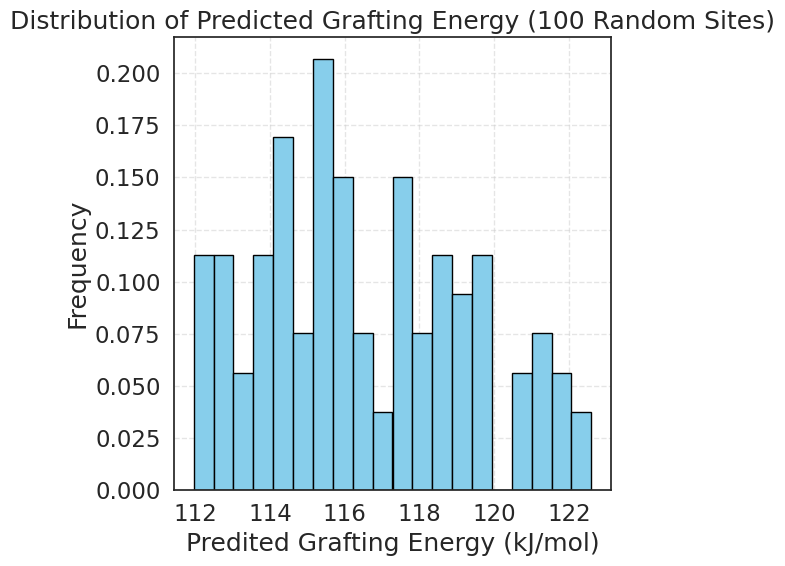

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(y_pred, bins=20, color='skyblue', edgecolor='black', density=True)
plt.xlabel(r'Predited Grafting Energy (kJ/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Grafting Energy (100 Random Sites)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
all_indices = np.arange(19368)

In [ ]:
X_all = local_coordinates[all_indices]
Y_all = graft_E[all_indices]

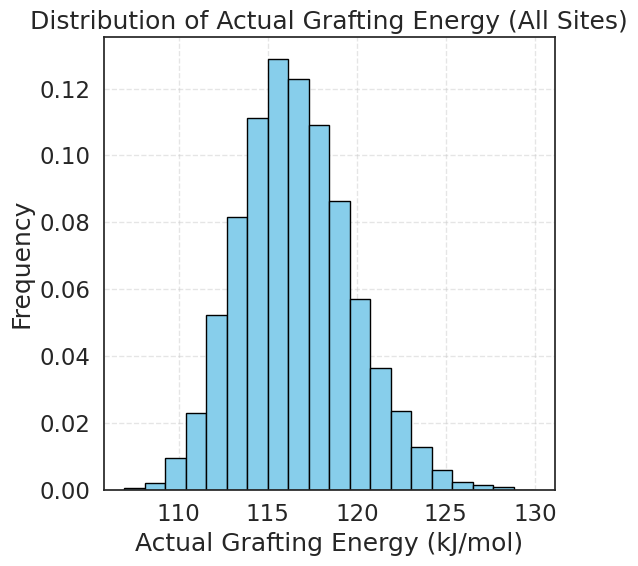

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(Y_all, bins=20, color='skyblue', edgecolor='black', density=True)
plt.xlabel(r'Actual Grafting Energy (kJ/mol)')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Grafting Energy (All Sites)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


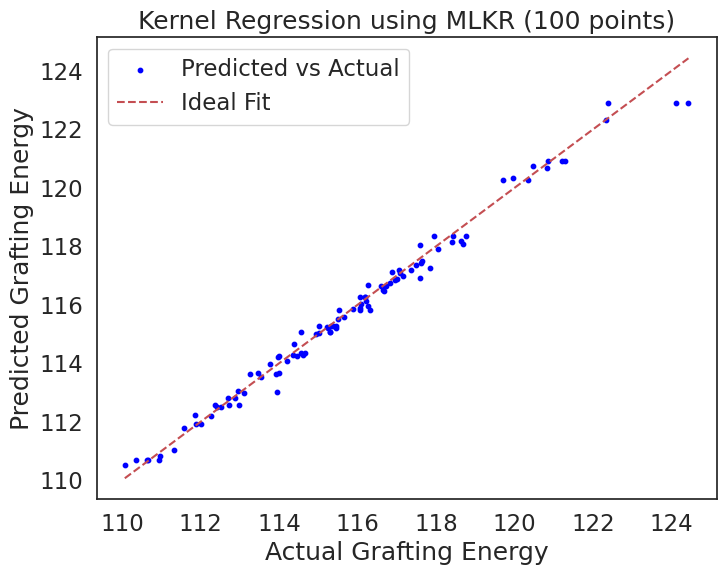

In [ ]:


X = local_coordinates[0:100]
Y = graft_E[0:100]


mlkr = MLKR()
X_transformed = mlkr.fit_transform(X, Y)


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_transformed, Y)


Y_pred = knn.predict(X_transformed)


error = np.abs(Y_pred - Y)


plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred, c='blue', s=10, label='Predicted vs Actual')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], 'r--', label='Ideal Fit')
plt.xlabel('Actual Grafting Energy')
plt.ylabel('Predicted Grafting Energy')
plt.title('Kernel Regression using MLKR (100 points)')
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

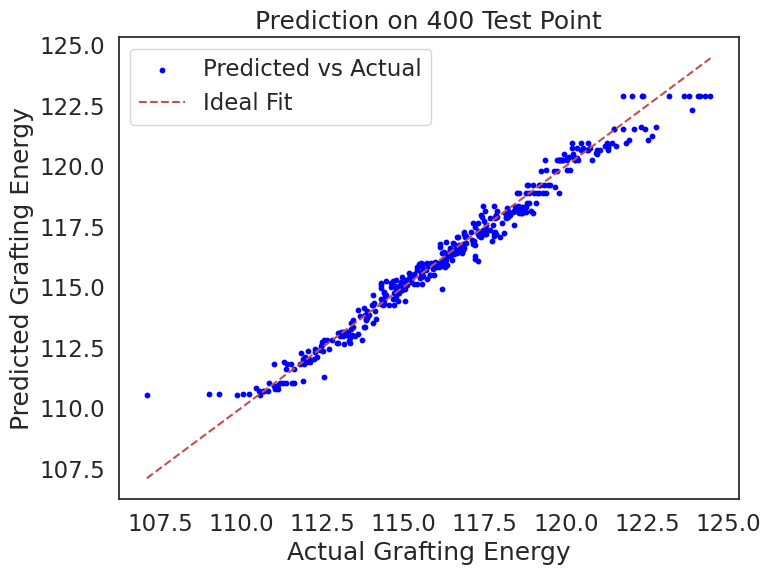

In [ ]:



train_indices = list(range(100))
test_indices = list(range(100, 500))

X_train = local_coordinates[train_indices]
Y_train = graft_E[train_indices]
X_test = local_coordinates[test_indices]
Y_test = graft_E[test_indices]


mlkr = MLKR()
X_train_transformed = mlkr.fit_transform(X_train, Y_train)


X_test_transformed = mlkr.transform(X_test)


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_transformed, Y_train)


Y_pred = knn.predict(X_test_transformed)


plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, c='blue', s=10, label='Predicted vs Actual')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual Grafting Energy')
plt.ylabel('Predicted Grafting Energy')
plt.title('Prediction on 400 Test Point')
plt.legend()
plt.show()

Sample indices: [2916, 5582, 19268, 363, 7114, 2201, 14698, 11965, 15237, 14528]
Sample values: [112.82518899 114.21586268 114.10821096 113.93812435 115.68127972
 114.1889104  120.28452293 116.1293036  121.20439782 117.03937933]


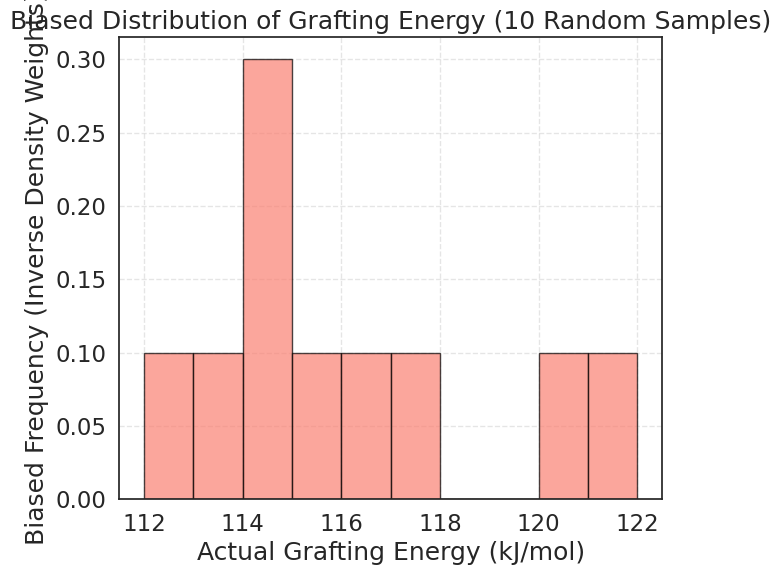

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Take 10 random samples
n_samples = 10
sample_indices = random.sample(range(len(graft_E)), n_samples)
sample_values = graft_E[sample_indices]

print("Sample indices:", sample_indices)
print("Sample values:", sample_values)

# Histogram setup with bin width = 1
bins = np.arange(int(min(sample_values)), int(max(sample_values)) + 2, 1)

# Normal histogram (counts)
counts, edges = np.histogram(sample_values, bins=bins, density=False)

# Convert counts to density
density = counts / counts.sum()

# Avoid division by zero for empty bins
with np.errstate(divide='ignore', invalid='ignore'):
    inv_density = np.where(density > 0, 1.0 / density, 0.0)

# Normalize weights
weights = inv_density / inv_density.sum()

# Plot weighted histogram
plt.figure(figsize=(7, 6))
plt.hist(sample_values, bins=bins, weights=np.ones_like(sample_values) * (weights.sum()/len(sample_values)),
         color="salmon", edgecolor="black", alpha=0.7)

plt.xlabel("Actual Grafting Energy (kJ/mol)")
plt.ylabel("Biased Frequency (Inverse Density Weights)")
plt.title("Biased Distribution of Grafting Energy (10 Random Samples)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


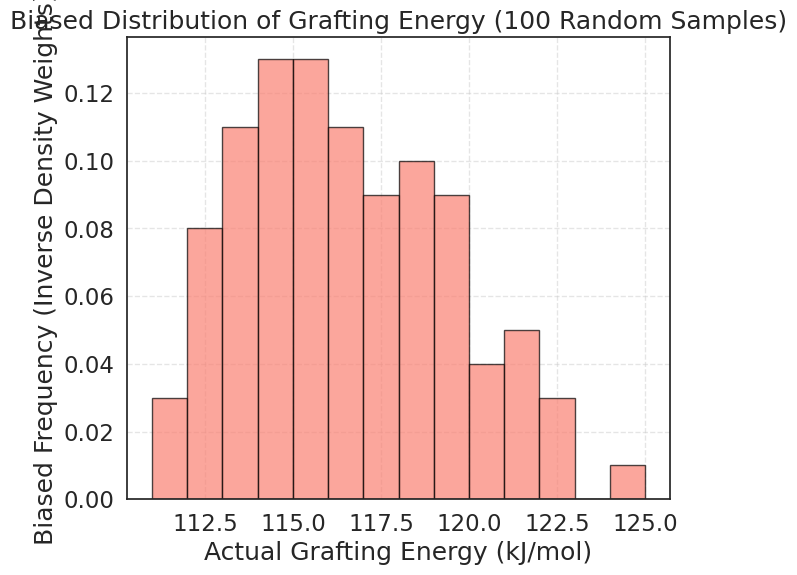

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the same 100-point sample you already defined
sample_values = Y_sample   # (from your earlier random sample of 100)

# Histogram setup with bin width = 1
bins = np.arange(int(min(sample_values)), int(max(sample_values)) + 2, 1)

# Normal histogram (counts)
counts, edges = np.histogram(sample_values, bins=bins, density=False)

# Convert counts to density
density = counts / counts.sum()

# Avoid division by zero for empty bins
with np.errstate(divide='ignore', invalid='ignore'):
    inv_density = np.where(density > 0, 1.0 / density, 0.0)

# Normalize weights
weights = inv_density / inv_density.sum()

# Plot weighted histogram
plt.figure(figsize=(7, 6))
plt.hist(sample_values, bins=bins,
         weights=np.ones_like(sample_values) * (weights.sum()/len(sample_values)),
         color="salmon", edgecolor="black", alpha=0.7)

plt.xlabel("Actual Grafting Energy (kJ/mol)")
plt.ylabel("Biased Frequency (Inverse Density Weights)")
plt.title("Biased Distribution of Grafting Energy (100 Random Samples)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


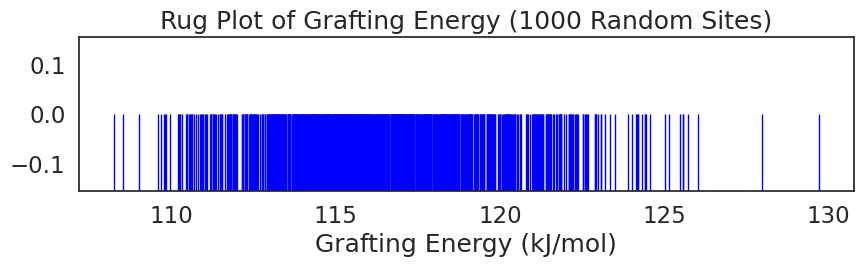

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Randomly sample 1000 sites from 19368
random_indices = random.sample(range(len(graft_E)), 1000)
Y_sample = graft_E[random_indices]

# Rug plot (no histogram, no KDE, just rug marks)
plt.figure(figsize=(10, 2))  # rugplots look better when wide
sns.rugplot(Y_sample, height=0.5, color="blue")

plt.xlabel("Grafting Energy (kJ/mol)")
plt.title("Rug Plot of Grafting Energy (1000 Random Sites)")
plt.show()


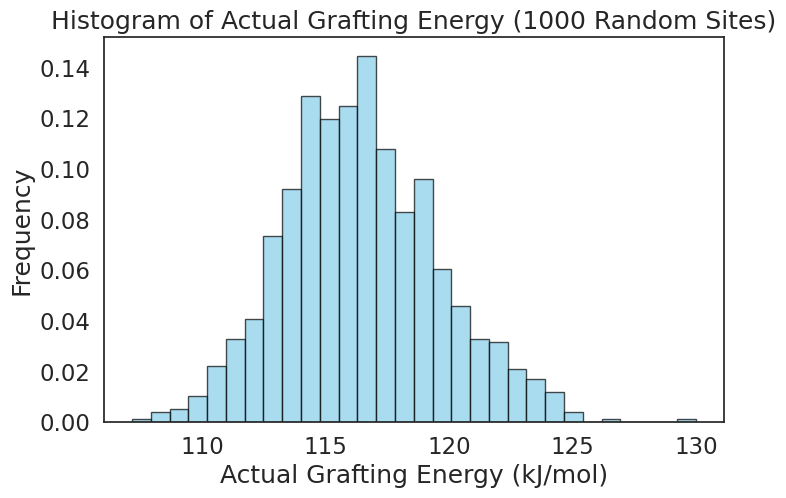

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random


random_indices_hist = random.sample(range(len(graft_E)), 1000)
Y_hist_sample = graft_E[random_indices_hist]


plt.figure(figsize=(8, 5))
plt.hist(Y_hist_sample, bins=30, density=True, color="skyblue", edgecolor="black", alpha=0.7)

plt.xlabel("Actual Grafting Energy (kJ/mol)")
plt.ylabel("Frequency")
plt.title("Histogram of Actual Grafting Energy (1000 Random Sites)")
plt.show()


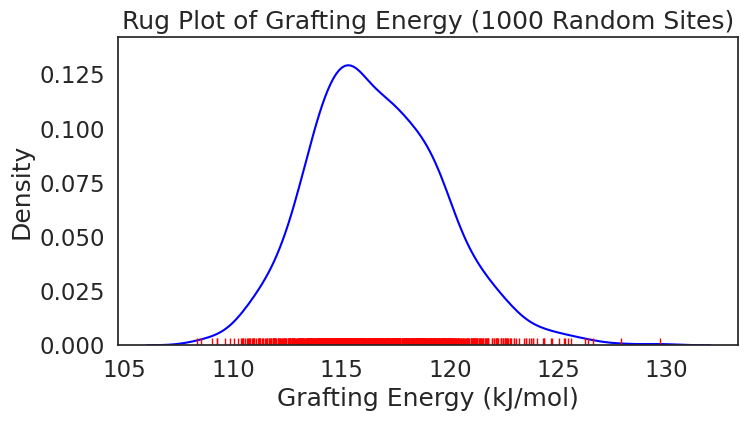

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random


random_indices = random.sample(range(len(graft_E)), 1000)
Y_sample = graft_E[random_indices]


plt.figure(figsize=(8, 4))
sns.kdeplot(Y_sample, fill=False, color="blue")
sns.rugplot(Y_sample, color="red")

plt.xlabel("Grafting Energy (kJ/mol)")
plt.ylabel("Density")
plt.title("Rug Plot of Grafting Energy (1000 Random Sites)")
plt.show()


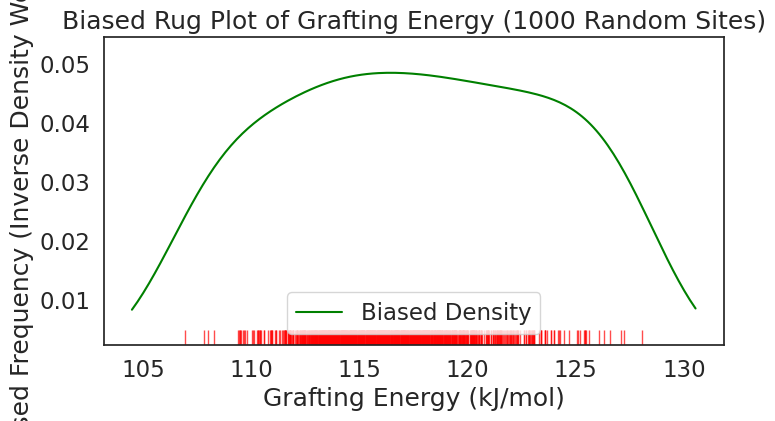

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import gaussian_kde


random_indices = random.sample(range(len(graft_E)), 1000)
Y_sample = graft_E[random_indices]


kde = gaussian_kde(Y_sample)
densities = kde(Y_sample)


weights = 1.0 / densities
weights /= np.sum(weights)


plt.figure(figsize=(8, 4))
sns.kdeplot(x=Y_sample, weights=weights, fill=False, color="green", label="Biased Density")
sns.rugplot(x=Y_sample, height=0.05, color="red", lw=1, alpha=0.7)  # rug can't directly use weights

plt.xlabel("Grafting Energy (kJ/mol)")
plt.ylabel("Biased Frequency (Inverse Density Weights)")
plt.title("Biased Rug Plot of Grafting Energy (1000 Random Sites)")
plt.legend()
plt.show()


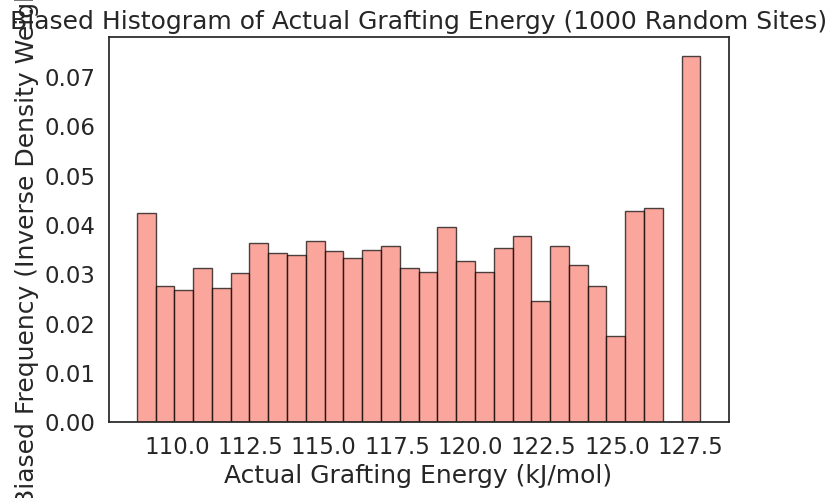

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import gaussian_kde

random_indices_biased = random.sample(range(len(graft_E)), 1000)
Y_biased_sample = graft_E[random_indices_biased]


kde = gaussian_kde(Y_biased_sample)
densities = kde(Y_biased_sample)

weights = 1 / densities
weights /= np.sum(weights)


plt.figure(figsize=(8, 5))
plt.hist(Y_biased_sample, bins=30, weights=weights, color="salmon", edgecolor="black", alpha=0.7)

plt.xlabel("Actual Grafting Energy (kJ/mol)")
plt.ylabel("Biased Frequency (Inverse Density Weights)")
plt.title("Biased Histogram of Actual Grafting Energy (1000 Random Sites)")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.kernel_ridge import KernelRidge


random_indices_1000 = random.sample(range(len(graft_E)), 1000)
X_train_1000 = local_coordinates[random_indices_1000]
Y_train_1000 = graft_E[random_indices_1000]

model = KernelRidge(alpha=1.0, kernel="rbf")
model.fit(X_train_1000, Y_train_1000)



KernelRidge(alpha=1.0, kernel='rbf')

In [ ]:

n_predict = 8000
predict_indices = random.sample(range(len(graft_E)), n_predict)

X_predict = local_coordinates[predict_indices]
Y_true_predict = graft_E[predict_indices]
Y_pred_predict = model.predict(X_predict)



In [ ]:

sample_indices_25 = random.sample(range(len(X_predict)), 25)

X_train_25 = X_predict[sample_indices_25]
Y_train_25 = Y_true_predict[sample_indices_25]

model_small = KernelRidge(alpha=1.0, kernel="rbf")
model_small.fit(X_train_25, Y_train_25)

Y_pred_25 = model_small.predict(X_predict)




In [ ]:
import numpy as np
from scipy.stats import gaussian_kde


kde = gaussian_kde(Y_pred_25)
densities = kde(Y_pred_25)


inv_density = 1.0 / densities
inv_density /= np.mean(inv_density)


Y_pred_biased = Y_pred_25 * inv_density




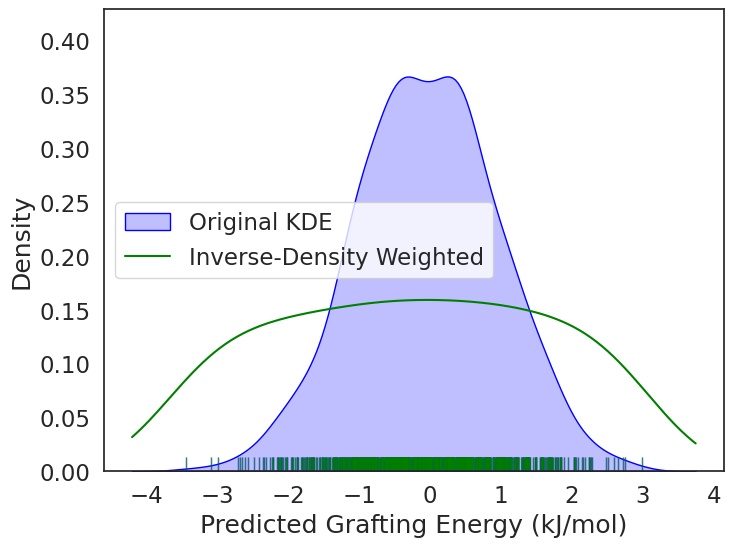

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

Y_pred_25 = np.random.normal(loc=0, scale=1, size=1000)

kde = gaussian_kde(Y_pred_25)
densities = kde(Y_pred_25)

inv_density = 1.0 / densities
inv_density /= np.mean(inv_density)

# Plot
plt.figure(figsize=(8,6))
sns.kdeplot(x=Y_pred_25, fill=True, color="blue", label="Original KDE")
sns.kdeplot(x=Y_pred_25, weights=inv_density, fill=False, color="green", label="Inverse-Density Weighted")

# Rug plots
sns.rugplot(x=Y_pred_25, color="blue", height=0.03, alpha=0.5)  # Original
# Weighted rug (option 1: simple rug without weights)
sns.rugplot(x=Y_pred_25, color="green", height=0.03, alpha=0.5)

plt.xlabel("Predicted Grafting Energy (kJ/mol)")
plt.ylabel("Density")
plt.legend()
plt.show()



Iteration 1: Predicted = 59.929, Actual = 110.645, Diff = 50.717
Iteration 2: Predicted = 91.911, Actual = 115.304, Diff = 23.393
Iteration 3: Predicted = 86.633, Actual = 118.388, Diff = 31.755
Iteration 4: Predicted = 69.822, Actual = 119.503, Diff = 49.681
Iteration 5: Predicted = 93.166, Actual = 129.529, Diff = 36.364
Iteration 6: Predicted = 104.381, Actual = 114.266, Diff = 9.885
Iteration 7: Predicted = 64.474, Actual = 116.753, Diff = 52.279
Iteration 8: Predicted = 114.071, Actual = 117.629, Diff = 3.558
Iteration 9: Predicted = 110.444, Actual = 120.318, Diff = 9.874
Iteration 10: Predicted = 114.868, Actual = 113.745, Diff = 1.123
Iteration 11: Predicted = 112.891, Actual = 113.711, Diff = 0.821
Iteration 12: Predicted = 108.290, Actual = 116.779, Diff = 8.489
Iteration 13: Predicted = 114.617, Actual = 115.517, Diff = 0.900
Iteration 14: Predicted = 94.921, Actual = 113.381, Diff = 18.460
Iteration 15: Predicted = 116.194, Actual = 118.061, Diff = 1.867
Iteration 16: Predi

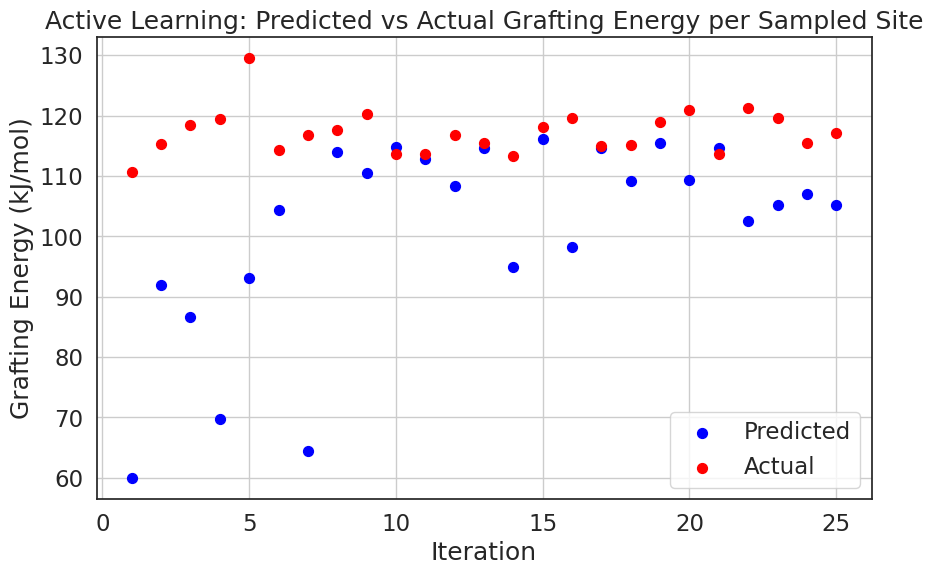

In [ ]:
import numpy as np
import random
from sklearn.kernel_ridge import KernelRidge
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

initial_indices = random.sample(range(len(graft_E)), 100)
X_train = local_coordinates[initial_indices]
Y_train = graft_E[initial_indices]

predict_indices = random.sample(range(len(graft_E)), 8000)
X_pool = local_coordinates[predict_indices]
Y_pool_actual = graft_E[predict_indices]


n_iterations = 25
diffs = []
sampled_pred = []
sampled_actual = []

plt.figure(figsize=(10, 6))

for i in range(n_iterations):

    model = KernelRidge(alpha=1.0, kernel="rbf")
    model.fit(X_train, Y_train)

    Y_pred_pool = model.predict(X_pool)


    kde = gaussian_kde(Y_pred_pool)
    densities = kde(Y_pred_pool)
    inv_density = 1.0 / densities
    inv_density /= np.sum(inv_density)


    sampled_index = np.random.choice(len(X_pool), p=inv_density)
    X_sampled = X_pool[sampled_index:sampled_index+1]
    Y_pred_sampled = Y_pred_pool[sampled_index]
    Y_actual_sampled = Y_pool_actual[sampled_index]


    diff = abs(Y_pred_sampled - Y_actual_sampled)
    diffs.append(diff)
    sampled_pred.append(Y_pred_sampled)
    sampled_actual.append(Y_actual_sampled)

    print(f"Iteration {i+1}: Predicted = {Y_pred_sampled:.3f}, Actual = {Y_actual_sampled:.3f}, Diff = {diff:.3f}")


    plt.scatter(i+1, Y_pred_sampled, color='blue', label='Predicted' if i==0 else "", s=50)
    plt.scatter(i+1, Y_actual_sampled, color='red', label='Actual' if i==0 else "", s=50)


    X_train = np.vstack([X_train, X_sampled])
    Y_train = np.append(Y_train, Y_actual_sampled)

    X_pool = np.delete(X_pool, sampled_index, axis=0)
    Y_pool_actual = np.delete(Y_pool_actual, sampled_index, axis=0)

plt.xlabel("Iteration")
plt.ylabel("Grafting Energy (kJ/mol)")
plt.title("Active Learning: Predicted vs Actual Grafting Energy per Sampled Site")
plt.legend()
plt.grid(True)
plt.show()
